# Introduction

This dataset contains information about adults' income and their different status like education, gender and martial status. 

First, we will did a deep-dive analysis into each field of the data, finding useful facts and provide some insights.

Next, we will build some machine learning models which tries to conduct a binary prediction if a person will make more than $50K a year.

The structure of this analysis is as follows:

1. Data loading and inspection

2. Exploratory Data Analysis

3. Model Training


# Data loading and inspection
## a. Loading libraries and data

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import collections
import functions
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler

As we can see, there are 14 features and 1 target variable, training data has 32561 observations and test data has 16281 observations. 

After the calculation, we can see the proportion of training data is around 67% and testing data is around 33%.

In [2]:
train = pd.read_csv('au_train.csv')
test = pd.read_csv('au_test.csv')
print('training dataset: ',train.shape,'\ntesting dataset: ',test.shape)

training dataset:  (32561, 15) 
testing dataset:  (16281, 15)


In [3]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## b. Dataset Description

Among all 14 features, *age*, *fnlwgt*,	*education-num*, *capital-gain*, *capital-loss* and *hours-per-week* are numerical features while *workclass*, *education*, *marital-status*, *occupation*, *relationship*, *race*, *sex* and *native-country* are categorical features.

There are 42 levels in *native-country*, the others have levels between 2 to 16.

In [4]:
print(train.dtypes,'\n\n')
cate_list = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
print('Categorical Feature Levels: ')
for i in cate_list:
    print('    ',i,len(collections.Counter(train[i]).keys()))

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
class             object
dtype: object 


Categorical Feature Levels: 
     workclass 9
     education 16
     marital-status 7
     occupation 15
     relationship 6
     race 5
     sex 2
     native-country 42


# Exploratory Data Analysis

## a. missing Value
First, let's check if there are missing values in the dataset.

As we can see, there are no missing values in both training and testing datasets.

In [5]:
print('train data missing values: ')
print({i:(train[i].isnull()).sum() for i in train.columns})
print('test data missing values: ')
print({i:(test[i].isnull()).sum() for i in test.columns})

train data missing values: 
{'age': 0, 'workclass': 0, 'fnlwgt': 0, 'education': 0, 'education-num': 0, 'marital-status': 0, 'occupation': 0, 'relationship': 0, 'race': 0, 'sex': 0, 'capital-gain': 0, 'capital-loss': 0, 'hours-per-week': 0, 'native-country': 0, 'class': 0}
test data missing values: 
{'age': 0, 'workclass': 0, 'fnlwgt': 0, 'education': 0, 'education-num': 0, 'marital-status': 0, 'occupation': 0, 'relationship': 0, 'race': 0, 'sex': 0, 'capital-gain': 0, 'capital-loss': 0, 'hours-per-week': 0, 'native-country': 0, 'class': 0}


## b. Target

Next, let's take a look at the target variable, there are 2 levels in it which are '<=50K' and '>50K', so it is a binary classification problem.

As we can see below, training and testing data has the same distribution of *class* variable. However, the dataset is **imbalanced**, almost 76% of training data is '<=50K', we should consider some rebalance techniques later.

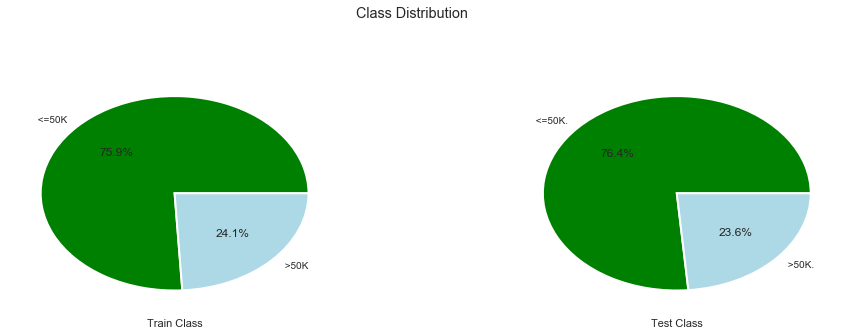

In [6]:
functions.draw_cir2(train,test,'class')

## c. Features

### 1. Feature Examine

First, let's take a look at correlations between different features to see if we can find something useful.

1. *education* and *education_num* are highly positive correlated
2. *sex* and *relationship* are highly negative correlated
3. *occupation* and *workclass* are positively correlated, which are true in normal cases
4. *sex* and *hours-per-week* are positively correlated, which are true in normal cases, male often works more than female.

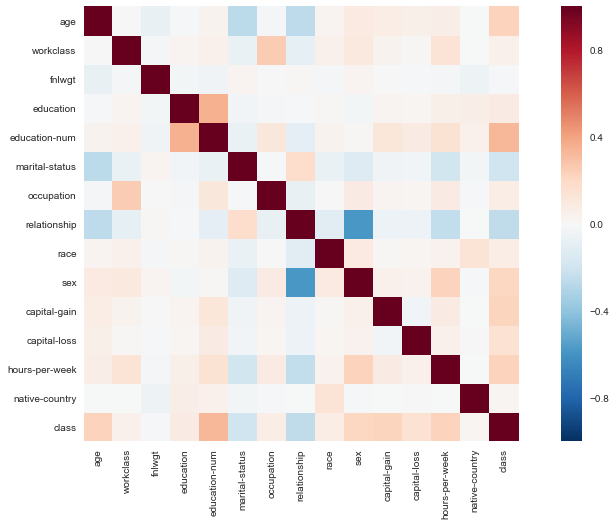

In [7]:
encoded_data,en = functions.number_encode_features(train)
plt.figure(figsize=(15,8))
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

**1. _education_ and _education-num_**

As we can see, *education* and *education-num* are actually the same, just used different encoding method, we should only keep one of them. 

Since the *education-num* is **ordinal** feature, we should keep it and get rid of *education*.

In [8]:
train[['education','education-num']][0:10]

,education,education-num
0,Bachelors,13
1,Bachelors,13
2,HS-grad,9
3,11th,7
4,Bachelors,13
5,Masters,14
6,9th,5
7,HS-grad,9
8,Masters,14
9,Bachelors,13


**2. _sex_ and _relationship_**

There are no obvious relationship we can find, it seems we can just leave it and let model learn the meanings.

In [9]:
train[['sex','relationship']][0:10]

,sex,relationship
0,Male,Not-in-family
1,Male,Husband
2,Male,Not-in-family
3,Male,Husband
4,Female,Wife
5,Female,Wife
6,Female,Not-in-family
7,Male,Husband
8,Female,Not-in-family
9,Male,Husband


### 2. Numerical Features

In [10]:
train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


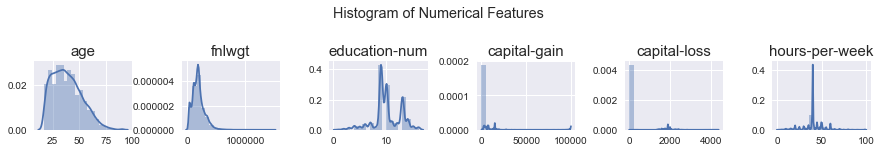

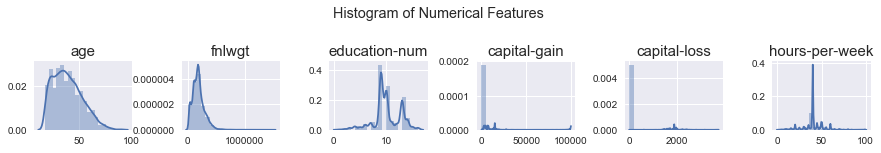

In [11]:
num_list = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
functions.draw_num_hist(train,num_list)
functions.draw_num_hist(test,num_list)

As we can see, training dataset and test dataset have similar distribution in numerical features.

After examine the histogram of numerical features, there are some useful informations:

1. *age* and *fnlwgt* are skewed, if the right tail ones are bad influential data point, it will cause model to focus on the oultiers--not robust, so it is better if we log-transform it.

2. *capital-gain* has abnormal values: 99999, we can assume they are missing valuesa and create new features to indicate it.

3. some of the features have lots of outliers, we can later use IQR method to detect them. However, it is no right answers whether to delete or not, we can try later.

**1. *fnlwgt* **

We use log-transformation on *fnlwgt* feature.

In [12]:
train['fnlwgt'] = np.log1p(train['fnlwgt'])
test['fnlwgt'] = np.log1p(test['fnlwgt'])
train['age'] = np.log1p(train['age'])
test['age'] = np.log1p(test['age'])

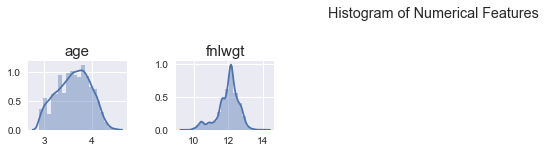

In [13]:
functions.draw_num_hist(train,['age','fnlwgt'])

**2. *capital-gain* **

There are 159 missing values in train and 85 in test based on our assumption.

We create a new feature *capital-gain_missing* to indicate it.

In [14]:
# add new features
print('capital-gain missing in train: ', sum(train['capital-gain'] == 99999))
print('capital-gain missing in test: ', sum(test['capital-gain'] == 99999))
train['capital-gain_missing'] = pd.Series([1 if i == 99999 else 0 for i in train['capital-gain']])
test['capital-gain_missing'] = pd.Series([1 if i == 99999 else 0 for i in test['capital-gain']])

capital-gain missing in train:  159
capital-gain missing in test:  85


**3. outliers** 

We use IQR method to detect outliers from dataset. Here are the numbers of outliers in each numerical features.

In [15]:
for i in list(train.describe().columns):
    print(i, len(functions.outliers_iqr(train[i])))

age 0
fnlwgt 1823
education-num 1198
capital-gain 2712
capital-loss 1519
hours-per-week 9008
capital-gain_missing 159


### 2. Categorical Features

There are 8 categorical features, which are *workclass*, *education*, *marital-status*, *occupation*, *relationship*, *race*, *sex* and *native-country*. 

First of all, draw the barplot of each of them.

As we can see below, some of them are highly imbalanced, such as *workclass*, *race* and *native-country.

Now, let's one by one analyze the relationship between them and target variable *class*.

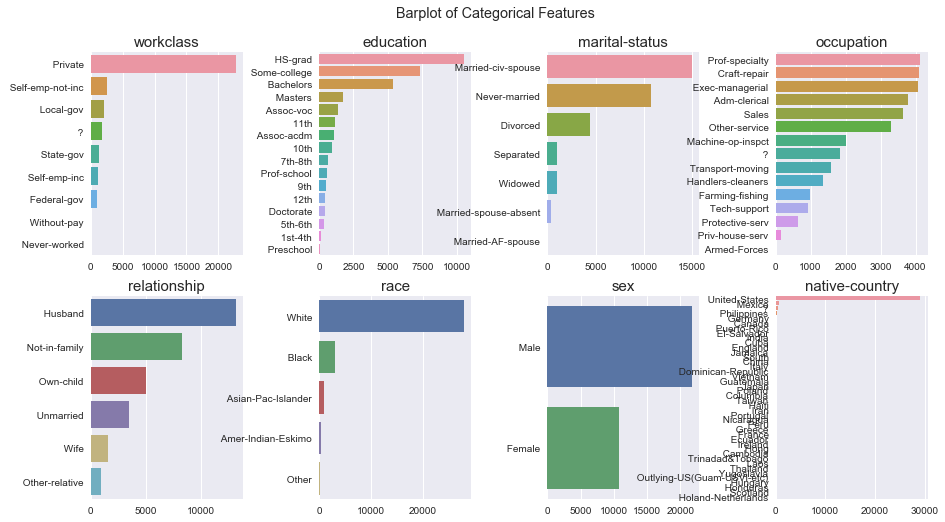

In [16]:
cate_list = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
functions.draw_cate_bar(train,cate_list)

**workclass**

Most of workclass is *Private*, in the rest of them, *self-emp-not-inc* and *Local-gov* are the top 2.

        Incorporated self employment: Refers to people who work for themselves in corporate entities.
        Unincorporated self employment: Refers to people who work for themselves in other legal entities.
        
As we can see, *self-emp-inc* has more high-income population among all workclass, by definition above and our data, we can understand why there is a big difference bewteen *self-emp-inc* and *self-emp-not-inc*.

Among three goverment workclass, *Federal-gov* has more high-income population whereas *State-gov* and *Local-gov* have similar ratio between two class.

*Without-pay* and *Never-worked* have no population in above 50K class which meets our prior knowledge.

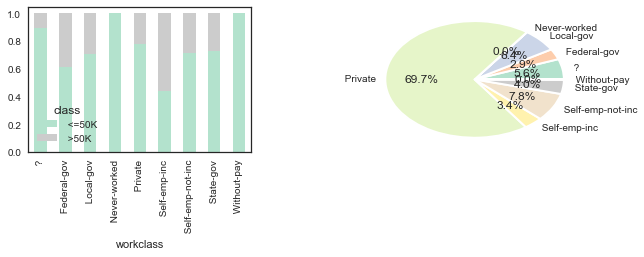

In [17]:
functions.draw_bar_class2(train,'workclass')

**education**

Most of the people is *High-School Gradute*, *Some-college* and *Bachelors*.

*Doctorate* and *Prefession-school* people have most high-income population, over 60% of them earn more than 50K per year, the next one is *Masters* people.

People who only recieve *pre-school* education have no higher income class.

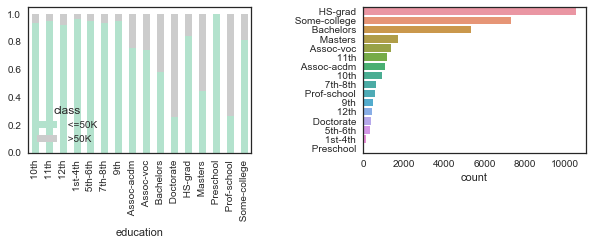

In [18]:
functions.draw_bar_class1(train,'education')

**marital-status**

As we can see, *Married-civ-spouse*, *Never-married* and *Divorced* are top three population people.

Among all of them, married people whose spouse are present have more high-income population than other, the rest of them are similar.

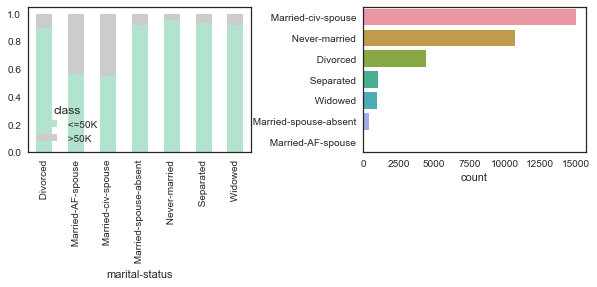

In [19]:
functions.draw_bar_class1(train,'marital-status')

**occupation**

Occupation are well distributed compared to other features.

Among all kinds of occupations, *Prof-specialty* and *Exec-managerial* are the two occupations have higher ratio, which** validate** the finding in education where *Prof-school* population has higher ratio.

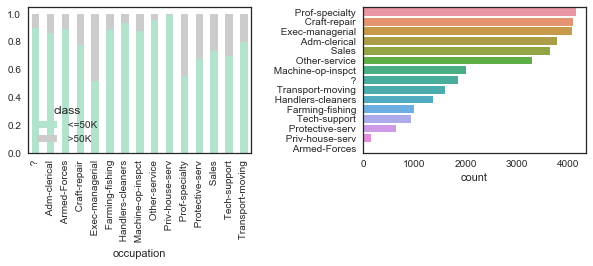

In [20]:
functions.draw_bar_class1(train,'occupation')

**relationship**

In the census, near 40% populations are *Husband* and 25% are not in family.

Married people(*Husband*, *Wife*) tends to have a higher ratio.

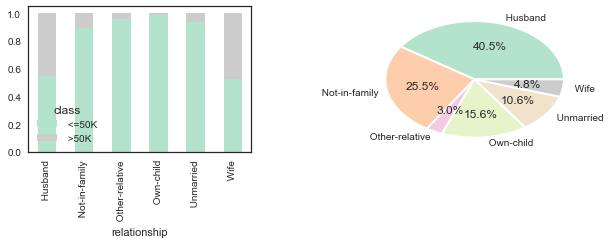

In [21]:
functions.draw_bar_class2(train,'relationship')

**race**

Most of people are *White* people, next is *Black* people.

*Asian & Pacific Islander* and *White* people have higher ratio than other races.

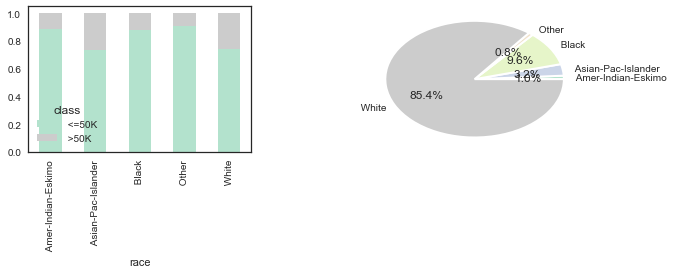

In [22]:
functions.draw_bar_class2(train,'race')

**sex**

We can see that *male* has more high-income population than *female* from the plot.

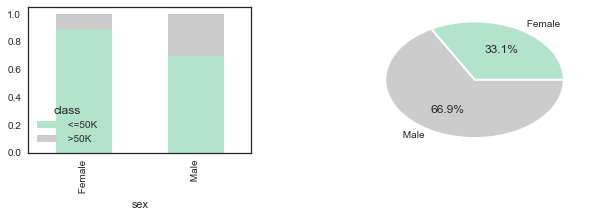

In [23]:
functions.draw_bar_class2(train,'sex')

**native-country**

Since the level of native-country is too much, we only look at top 10 population countries.

As we can see, most of the people are from *United-States*, the next one is *Mexico*.

*India* people has biggest ratio and *Mexico* people has least ratio among the 10 countries.

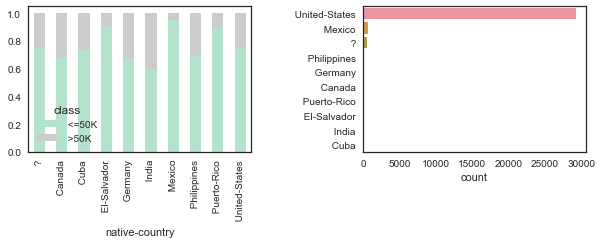

In [24]:
functions.draw_bar_class1(train,'native-country')